In [1]:
import os

import aquamonitor as am
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import rioxarray as rio
import seaborn as sn
import xarray as xr

%load_ext rpy2.ipython

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Updating critical loads for water

## Part A: Input data

The notebook `01_interpolate_toc_no3.ipynb` made an initial attempt at interpolating TOC and NO3 over space and time. After further discussion with Cathrine and Kari, we have decided on the following workflow for the Critical Loads project:

 * **TOC should be interpolated in space, but not time**. Use data for 2019 for the 785 "near-natural" lakes in the 1000 Lakes project (used for TEOTIL3), plus the 78 tidstrendsjøer.
 
 * **NO3 should be interpolated over space and time**. Use the same lakes as above, but with data for 1990 to 2021
 
 * For each lake, the elevation (in metres) and the mean annual runoff (1990 to 2021) for the outlet co-ordinates should be included as explanatory variables

For more details, see Kari's Word document on the NIVA network:

    K:\Prosjekter\langtransporterte forurensninger\11127 ICP MM\Projects\2022 Tålegrenseprosjekt\Oppdatering CL\Vurderinger oppdatering CLacid og empCL.docx

This notebook downloads, processes and combines the various input datasets.

## 1. Get water chemistry data

Code in this section is modified from Section 1 of `01_interpolate_toc_no3.ipynb`.

In [3]:
# Login to AM
token = am.login()

Please enter your credentials.


Username:  ········
Password:  ········


In [4]:
# Period of interest
st_yr = 1990
end_yr = 2021

# Output CSV to create
csv_path = f"/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_chem_toc_no3_{st_yr}-{end_yr}.csv"

st_dt = f"01.01.{st_yr}"
end_dt = f"31.12.{end_yr}"

In [5]:
def tidy_water_chem(df):
    """Tidy raw water chemistry data from Aquamonitor. Gets just TOC
    and NO3 data for surface samples, and calculates annual means for
    each site.

    Note: In Aquamonitor there are two relevant parameters for NO3:
    'NO3+NO2-N' and 'NO3-N'. The code here combines them into a single
    series called 'NO3' i.e. NO2 is assumed to be negligible.
    """
    # Just pars of interest
    par_list = ["TOC", "NO3+NO2-N", "NO3-N"]
    df = df.query("parameter_name in @par_list")

    # Only surface samples
    df = df.query("(depth1 == 0) and (depth2 == 0)")

    # Add year
    df["year"] = df["sample_date"].dt.year

    # Tidy and average duplicates
    df["par_unit"] = df["parameter_name"] + "_" + df["unit"]
    df.drop(
        [
            "project_id",
            "project_name",
            "station_code",
            "depth1",
            "depth2",
            "sample_date",
            "parameter_name",
            "unit",
            "flag",
        ],
        axis="columns",
        inplace=True,
    )
    id_cols = ["station_id", "station_name", "year", "par_unit"]
    df = df.groupby(id_cols).mean()
    df = df.unstack("par_unit")
    df.columns = df.columns.get_level_values(1)
    df.reset_index(inplace=True)

    # Most samples report NO3+NO2, but some just have NO3. Use NO3+NO2
    # where possible and patch with NO3
    df["NO3+NO2-N_µg/l"] = df["NO3+NO2-N_µg/l"].combine_first(df["NO3-N_µg/l"])

    # Remove special chars from col names
    df.rename(
        {"TOC_mg/l": "TOC_mgpl", "NO3+NO2-N_µg/l": "NO3_NO2_ugpl"},
        axis="columns",
        inplace=True,
    )
    df = df[["station_id", "station_name", "year", "TOC_mgpl", "NO3_NO2_ugpl"]]

    return df

### 1.1. The "1000 Lakes" dataset

This dataset provides good spatial coverage, but only for 1995 and 2019. In the code below, I have filtered the dataset to only include the 785 "near-natural" sites identified during development of TEOTIL3 (see the notebook [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-7a_non_agri_diffuse_inputs.ipynb)).

In [6]:
# Find the project code for the 2019 '1000 Lakes' survey
proj_df = am.get_projects(token=token)
proj_df.query("project_name.str.contains('Nasjonal')", engine="python")

,project_id,project_code,project_name,description
1198,12433,190091,Nasjonal Innsjøundersøkelse 2019,1000-sjøer undersøkelse gjennomført i 2019


In [7]:
# Get water all chem between 1995 and 2019
proj_id = 12433
stn_df = am.get_project_stations(proj_id, token=token, return_coords=True)
wc_df_1klakes = am.get_project_chemistry(proj_id, st_dt, end_dt, token=token)

In [8]:
# Map stations
nivapy.spatial.quickmap(stn_df, cluster=True, popup="station_id", kartverket=True)

In [9]:
# Tidy water chem
wc_df_1klakes = tidy_water_chem(wc_df_1klakes)

# Join station data
stn_df = stn_df[["station_id", "longitude", "latitude"]]
wc_df_1klakes = pd.merge(wc_df_1klakes, stn_df, how="left", on="station_id")
wc_df_1klakes = nivapy.spatial.wgs84_dd_to_utm(
    wc_df_1klakes, lat="latitude", lon="longitude", utm_zone=33
)
del wc_df_1klakes["longitude"], wc_df_1klakes["latitude"]
wc_df_1klakes.dropna(subset=["utm_east"], inplace=True)
wc_df_1klakes = wc_df_1klakes[
    [
        "station_id",
        "station_name",
        "utm_north",
        "utm_east",
        "utm_zone",
        "year",
        "TOC_mgpl",
        "NO3_NO2_ugpl",
    ]
]

# Filter to just "natural" lakes identified for TEOTIL3
data_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
cat_gdf = gpd.read_file(teo_gpkg, layer="1000_lakes_natural_catchments", driver="GPKG")
stn_ids = cat_gdf["station_id"].unique().tolist()
wc_df_1klakes = wc_df_1klakes.query("station_id in @stn_ids")

print(
    len(wc_df_1klakes["station_id"].unique()), "'near-natural' stations in the dataset."
)
wc_df_1klakes.head()

/tmp/ipykernel_9595/1959786710.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["sample_date"].dt.year
/tmp/ipykernel_9595/1959786710.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["par_unit"] = df["parameter_name"] + "_" + df["unit"]
/tmp/ipykernel_9595/1959786710.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

785 'near-natural' stations in the dataset.


,station_id,station_name,utm_north,utm_east,utm_zone,year,TOC_mgpl,NO3_NO2_ugpl
0,26070,Langtjern,6.634299e+06,323345.999797,33,1995,11.7,46.0
1,26070,Langtjern,6.634299e+06,323345.999797,33,1996,19.6,13.0
2,26070,Langtjern,6.634299e+06,323345.999797,33,1997,11.0,54.0
3,26070,Langtjern,6.634299e+06,323345.999797,33,1998,13.1,58.0
4,26070,Langtjern,6.634299e+06,323345.999797,33,1999,13.1,53.0


### 1.2. Tidstrendsjøene

Tidstrendsjøene provide a detailed record of temporal changes for 78 sites across Norway. Unfortunately, there isn't a single project in AM that provides these data - see the e-mail from Kari received 01.02.2023 at 15.20. Instead, I have exported the relevant data manually from RESA to Excel.

In [10]:
# Read data
xl_path = r"tidstrendsjoer_resa_1990-2021.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="stations")
stn_df = nivapy.spatial.utm_to_wgs84_dd(
    stn_df, zone="utm_zone", east="utm_east", north="utm_north"
)
wc_df_biolok = pd.read_excel(xl_path, sheet_name="data")

In [11]:
# Map stations
nivapy.spatial.quickmap(
    stn_df,
    lat_col="lat",
    lon_col="lon",
    cluster=True,
    popup="station_id",
    kartverket=True,
)

In [12]:
# Add year
wc_df_biolok["year"] = wc_df_biolok["sample_date"].dt.year

# Tidy
del wc_df_biolok["sample_date"]
id_cols = ["station_id", "station_name", "utm_north", "utm_east", "utm_zone", "year"]
wc_df_biolok = wc_df_biolok.groupby(id_cols).mean().reset_index()
wc_df_biolok = wc_df_biolok[id_cols +  ["TOC_mgpl", "NO3_NO2_ugpl"]]

print(len(wc_df_biolok["station_id"].unique()), "unique stations in the dataset.")
wc_df_biolok.head()

78 unique stations in the dataset.


,station_id,station_name,utm_north,utm_east,utm_zone,year,TOC_mgpl,NO3_NO2_ugpl
0,100,Breidlivatnet,6.658481e+06,229260.023831,33,1990,4.72,26.0
1,100,Breidlivatnet,6.658481e+06,229260.023831,33,1991,3.56,27.0
2,100,Breidlivatnet,6.658481e+06,229260.023831,33,1992,5.90,6.0
3,100,Breidlivatnet,6.658481e+06,229260.023831,33,1993,6.60,28.0
4,100,Breidlivatnet,6.658481e+06,229260.023831,33,1994,5.70,66.0


### 1.3. Combine datasets

In [13]:
# Combine
df = pd.concat([wc_df_1klakes, wc_df_biolok], axis="rows")

# Some lakes are in both projects
df = df.drop_duplicates(subset=["station_id", "year"], keep="first").reset_index(
    drop=True
)
del df["utm_zone"]

df.head()

,station_id,station_name,utm_north,utm_east,year,TOC_mgpl,NO3_NO2_ugpl
0,26070,Langtjern,6.634299e+06,323345.999797,1995,11.7,46.0
1,26070,Langtjern,6.634299e+06,323345.999797,1996,19.6,13.0
2,26070,Langtjern,6.634299e+06,323345.999797,1997,11.0,54.0
3,26070,Langtjern,6.634299e+06,323345.999797,1998,13.1,58.0
4,26070,Langtjern,6.634299e+06,323345.999797,1999,13.1,53.0


### 1.4. Explore data

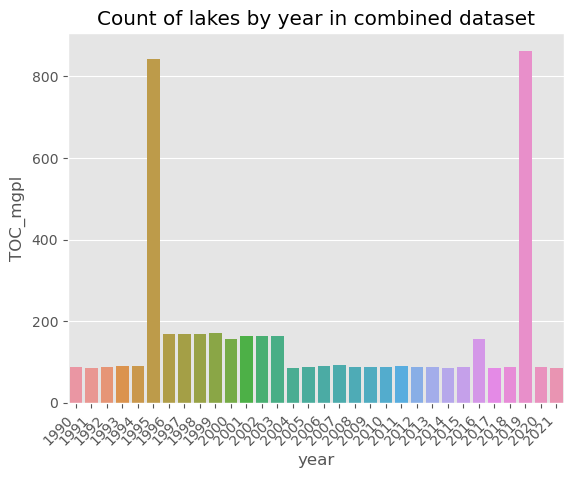

In [14]:
# Number of data points per year
agg_df = df.groupby("year").count()[["TOC_mgpl"]].reset_index()
ax = sn.barplot(data=agg_df, x="year", y="TOC_mgpl")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Count of lakes by year in combined dataset");

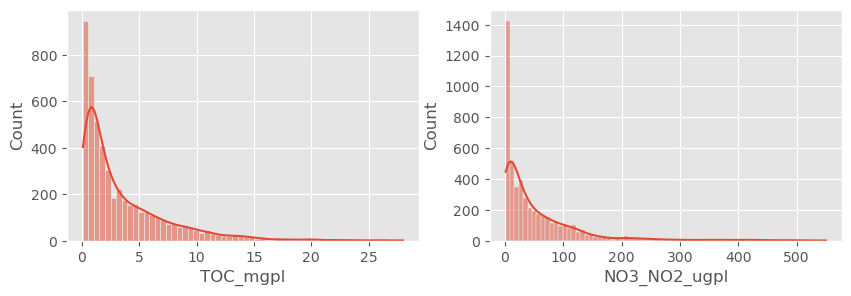

In [15]:
# Histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sn.histplot(data=df, x="TOC_mgpl", kde=True, ax=axes[0])
sn.histplot(data=df, x="NO3_NO2_ugpl", kde=True, ax=axes[1]);

<AxesSubplot:xlabel='NO3_NO2_ugpl'>

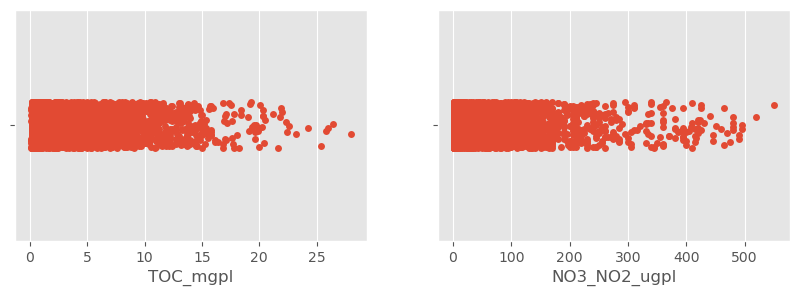

In [16]:
# Strip plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sn.stripplot(data=df, x="TOC_mgpl", ax=axes[0])
sn.stripplot(data=df, x="NO3_NO2_ugpl", ax=axes[1])

These data seem reasonable and there are no really extreme outliers to be removed.

## 2. Get elevation and mean runoff for lake outlets

Extract elevation and mean runoff (1991 to 2020) for outlet co-ordinates. Runoff is based on the new "runoff normal" from NVE and elevation is based on the 40 m DTM created for my catchment delineation tool.

In [17]:
ro_grid_path = r"/home/jovyan/shared/teotil3/nve_hbv_data/runoff_1991-2020_mm_year.tif"
elev_grid_path = r"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_40m/norway_kartverket_40m_dtm_utm_z33.tif"

# Get list of unique station co-ords
all_stns_df = df.drop_duplicates(subset=["station_id"], keep="first")[
    ["station_id", "station_name", "utm_north", "utm_east"]
]
x_indexer = xr.DataArray(
    all_stns_df["utm_east"], dims=["station_id"], coords=[all_stns_df["station_id"]]
)
y_indexer = xr.DataArray(
    all_stns_df["utm_north"], dims=["station_id"], coords=[all_stns_df["station_id"]]
)

path_dict = {"runoff_mmpyr": ro_grid_path, "elevation_m": elev_grid_path}
for par, grid_path in path_dict.items():
    with rio.open_rasterio(grid_path) as ds:
        if par == "runoff_mmpyr":
            ds = ds.rio.interpolate_na(method="nearest")

        # Get values for points
        pt_ds = ds.sel(x=x_indexer, y=y_indexer, method="nearest")
        pt_df = pt_ds.to_dataframe(name=par).reset_index()

        # Join
        df = pd.merge(df, pt_df[["station_id", par]], how="left", on="station_id")
        df[par] = df[par].round(0).astype(int)

df.head()

,station_id,station_name,utm_north,utm_east,year,TOC_mgpl,NO3_NO2_ugpl,runoff_mmpyr,elevation_m
0,26070,Langtjern,6.634299e+06,323345.999797,1995,11.7,46.0,532,274
1,26070,Langtjern,6.634299e+06,323345.999797,1996,19.6,13.0,532,274
2,26070,Langtjern,6.634299e+06,323345.999797,1997,11.0,54.0,532,274
3,26070,Langtjern,6.634299e+06,323345.999797,1998,13.1,58.0,532,274
4,26070,Langtjern,6.634299e+06,323345.999797,1999,13.1,53.0,532,274


In [18]:
# Build geodataframe for plotting
all_stns_df = df.drop_duplicates(subset=["station_id"], keep="first")
gdf = gpd.GeoDataFrame(
    all_stns_df,
    geometry=gpd.points_from_xy(
        all_stns_df["utm_east"], all_stns_df["utm_north"], crs="epsg:25833"
    ),
).reset_index(drop=True)

<AxesSubplot:>

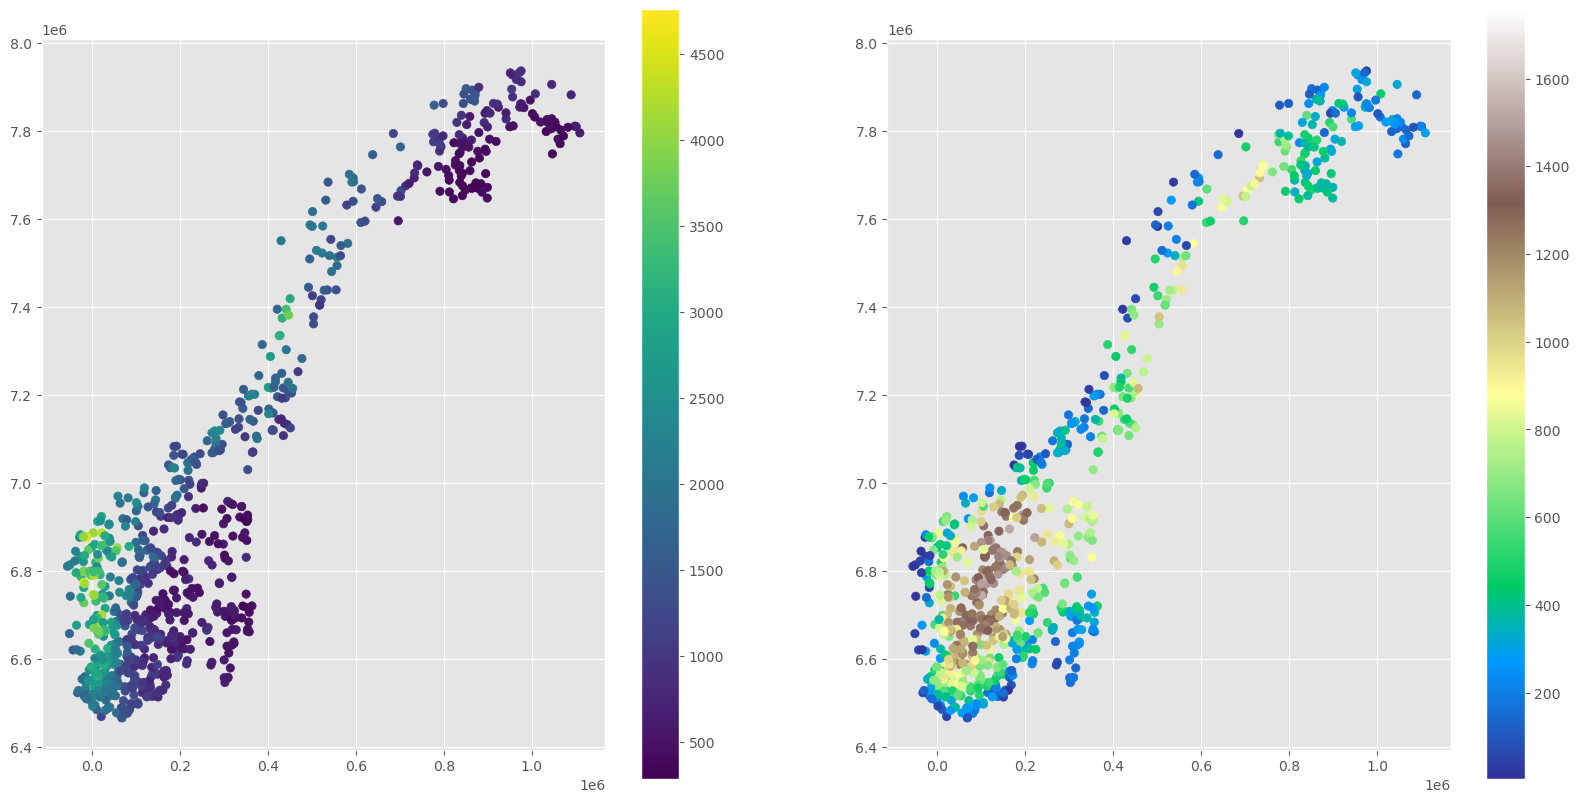

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
gdf.plot(column="runoff_mmpyr", ax=axes[0], legend=True)
gdf.plot(column="elevation_m", ax=axes[1], cmap="terrain", legend=True)

In [20]:
gdf.describe()

,station_id,utm_north,utm_east,year,TOC_mgpl,NO3_NO2_ugpl,runoff_mmpyr,elevation_m
count,863.000000,8.630000e+02,8.630000e+02,863.000000,862.000000,863.000000,863.000000,863.000000
mean,25366.901506,6.957932e+06,2.825413e+05,1994.988413,2.776932,47.834299,1484.957126,647.477404
std,10280.398265,4.338489e+05,2.999521e+05,3.820188,2.897440,58.586752,931.722559,395.887290
min,100.000000,6.465531e+06,-5.524240e+04,1990.000000,0.100000,1.000000,283.000000,2.000000
25%,26263.500000,6.628379e+06,5.830163e+04,1995.000000,0.492500,4.000000,717.500000,316.000000
50%,26569.000000,6.795848e+06,1.674203e+05,1995.000000,1.700000,28.000000,1284.000000,614.000000
75%,26850.500000,7.144995e+06,3.751410e+05,1995.000000,4.200000,73.000000,2055.500000,942.000000
max,71725.000000,7.935722e+06,1.109404e+06,2019.000000,19.700000,424.000000,4760.000000,1758.000000


In [21]:
# Save
df.to_csv(csv_path, index=False)